# Imports

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from warnings import simplefilter
import seaborn as sns
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Get data

In [2]:
df = pd.read_csv("/kaggle/input/ibm-classification-eda/data.csv", parse_dates=['Date'])

# Feature Engineering

### Categorical variables

In [3]:
# One hot encode categorical features
categorical_cols = ['Sector']
df = pd.get_dummies(
    data=df,
    columns=categorical_cols,
    dtype=int
)

In [4]:
# Change symbol to stock id
df['Symbol'] = df['Symbol'].rank(method='dense', ascending=False).astype(int)

### Date-related

In [5]:
# Get year, month and day
df['Year'] = df['Date'].dt.year.astype(int)
df['Month'] = df['Date'].dt.month.astype(int)
df['Day'] = df['Date'].dt.day.astype(int)

### Static (based off of today's data)

In [6]:
# Daily variation (high - low) / open
df['Daily Variation'] = (df['High'] - df['Low']) / df['Open']

# Downward pressure on the stock (high - close) / open
df['Downward Pressure'] = (df['High'] - df['Close']) / df['Open']

# Upward pressure on the stock (low - open) / open
df['Upward Pressure'] = (df['Low'] - df['Open']) / df['Open']

 ### Shifted

In [7]:
# Macro columns
macro_cols = ['Unemployment Rate (%)',
       'Consumer Confidence Index', 'CPI All Items', 'Inflation (%)',
       'Monthly Average Mortgage Rate (%)',
       'Corporate Bond Yield', 'GDP Per Capita', 'Quarterly Real GDP',
       'Quarterly GDP Growth Rate (%)', 'Home Price Index']

# List of days and cols to to shift by
to_shift_by = [1, 3, 5, 10, 15, 30, 60]
to_shift = macro_cols + ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'S&P500']

# Get shifted dataframes for each time period
shifted_dfs = []
groups = df.groupby('Symbol')[to_shift]
for d in to_shift_by:
    # Get shifted df
    shifted_df = groups.shift(periods=d)
    
    # Edit column names
    shifted_df.columns = [f"{c} {d}-Day Shifted" for c in to_shift]
    
    # Append to list
    shifted_dfs.append(shifted_df)

# Concatenate shifted dataframes to original dataframe
df = pd.concat(
    [df] + shifted_dfs,
    axis=1
)

### Returns/Changes

In [8]:
# % Change cols
pct_change_cols = ['Adj Close', 'S&P500'] + macro_cols

# Get shifted dataframes for each time period
change_dfs = []
for d in to_shift_by:
    # Get dataframe of shifted columns
    shifted_cols = [f"{c} {d}-Day Shifted" for c in pct_change_cols]
    shifted_df = df[shifted_cols]
    
    # Calculate percentage change
    pct_changes = 100 * (np.array(df[pct_change_cols]) - np.array(shifted_df)) / np.array(shifted_df)
    change_df = pd.DataFrame(
        data=pct_changes,
        columns=[f"{c} {d}-Day % Change" for c in pct_change_cols]
    )

    # Append to list
    change_dfs.append(change_df)

# Append to original dataframe
df = pd.concat(
    [df] + change_dfs,
    axis=1
)

### Rolling

In [9]:
# Columns to calculate SMA, EMA, std for
cols = ['Adj Close', 'Volume']
days = [7, 12, 14, 26]

# List of dataframes of rolling features
rolling_dfs = []

# For each lookback, calculate rolling features
for d in days:
    # Get groupby object
    groupby = df.groupby('Symbol')[cols]
    
    # SMA
    df_sma = groupby.transform(lambda x: x.rolling(d).mean())
    df_sma.columns = [f"{c} {d}-Day SMA" for c in cols]

    # EMA
    df_ema = groupby.transform(lambda x: x.ewm(span=d, min_periods=d).mean())
    df_ema.columns = [f"{c} {d}-Day EMA" for c in cols]

    # Std
    df_std = groupby.transform(lambda x: x.rolling(d).std())
    df_std.columns = [f"{c} {d}-Day std" for c in cols]
    
    # Create df of all rolling features and append to list
    rolling_df = pd.concat(
        [df_sma, df_ema, df_std],
        axis=1
    )
    rolling_dfs.append(rolling_df)
    
# Append to original dataframe
df = pd.concat(
    [df] + rolling_dfs,
    axis=1
)

### Technical indicators

In [10]:
##################################################
# Bollinger Bands
##################################################

# Bollinger bands
df['Adj Close 7-Day Upper Bollinger Band'] = df['Adj Close 7-Day SMA'] + (2 * df['Adj Close 7-Day std'])
df['Adj Close 7-Day Lower Bollinger Band'] = df['Adj Close 7-Day SMA'] - (2 * df['Adj Close 7-Day std'])

# Distance to bollinger bands
df['Distance to Adj Close 7-Day Upper Bollinger Band'] = df['Adj Close'] - df['Adj Close 7-Day Upper Bollinger Band']
df['Distance to Adj Close 7-Day Lower Bollinger Band'] = df['Adj Close'] - df['Adj Close 7-Day Lower Bollinger Band']

In [11]:
###################################################
# Average True Range (ATR)
###################################################

# Calculate 3 measures of volatility (that we will take average of for ATR)
high_minus_low = df['High'] - df['Low']
high_minus_yday_adj_close = (df['High'] - df['Adj Close 1-Day Shifted']).abs()
low_minus_yday_adj_close = (df['Low'] - df['Adj Close 1-Day Shifted']).abs()

# Calculate true range and (7-day) average true range
df['True Range'] = np.maximum.reduce([high_minus_low, high_minus_yday_adj_close, low_minus_yday_adj_close])
df['True Range 26-Day SMA'] = df.groupby('Symbol')['True Range'].transform(lambda x: x.rolling(26).mean())

In [12]:
###################################################
# Moving Average Convergence Divergence (MACD)
###################################################

# MACD https://www.investopedia.com/terms/m/macd.asp
df['MACD'] = df['Adj Close 12-Day EMA'] - df['Adj Close 26-Day EMA']
df['MACD Signal Line'] = df.groupby('Symbol')['MACD'].transform(lambda x: x.ewm(span=9, min_periods=9).mean())
df['MACD Histogram'] = df['MACD'] - df['MACD Signal Line']

In [13]:
#######################################################################
# Moving Average Convergence Divergence (Volatility Adjusted) (MACD-V)
#######################################################################

# MACD-v (same as MACD but normalized for vol)
df['MACD-V'] = 100 * (df['Adj Close 12-Day EMA'] - df['Adj Close 26-Day EMA']) / df['True Range 26-Day SMA']
df['MACD-V Signal Line'] = df.groupby('Symbol')['MACD-V'].transform(lambda x: x.ewm(span=9, min_periods=9).mean())
df['MACD-V Histogram'] = df['MACD-V'] - df['MACD-V Signal Line']

In [14]:
###################################################
# Stochastic Oscillator
###################################################

# Get min and max prices over last 14 days
min_prices = df.groupby('Symbol')['Low'].transform(lambda x: x.rolling(14).min())
max_prices = df.groupby('Symbol')['High'].transform(lambda x: x.rolling(14).max())

# Stochatic Oscillator https://www.investopedia.com/terms/s/stochasticoscillator.asp
df['Stochastic Oscillator %K'] = 100 * (df['Close'] - min_prices) / (max_prices - min_prices)
df['Stochastic Oscillator %D'] = df.groupby('Symbol')['Stochastic Oscillator %K'].transform(lambda x: x.rolling(3).mean())
df['Stochastic Oscillator Histogram'] = df['Stochastic Oscillator %K'] - df['Stochastic Oscillator %D']

### Target

In [15]:
# Calculate Forward Return
df['1-week Forward Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(-5)
df['1-week Forward Return'] = (df['1-week Forward Adj Close'] - df['Adj Close']) / df['Adj Close']

# Create targets from forward returns (sign of return). Convert signs that are 0 to 1 and -1 to 0
df['1-week Forward Return Sign'] = np.sign(df['1-week Forward Return'])
df['1-week Forward Return Sign'] = df['1-week Forward Return Sign'].replace({0: 1})
df['1-week Forward Return Sign'] = df['1-week Forward Return Sign'].replace({-1: 0})

# Drop redundant columns
df.drop(['1-week Forward Adj Close', '1-week Forward Return'], axis=1, inplace=True)

### Plots for a single stock

In [16]:
# Get dataframe of some stock to use for plots
test_df = df[df['Symbol'] == 1].tail(150)

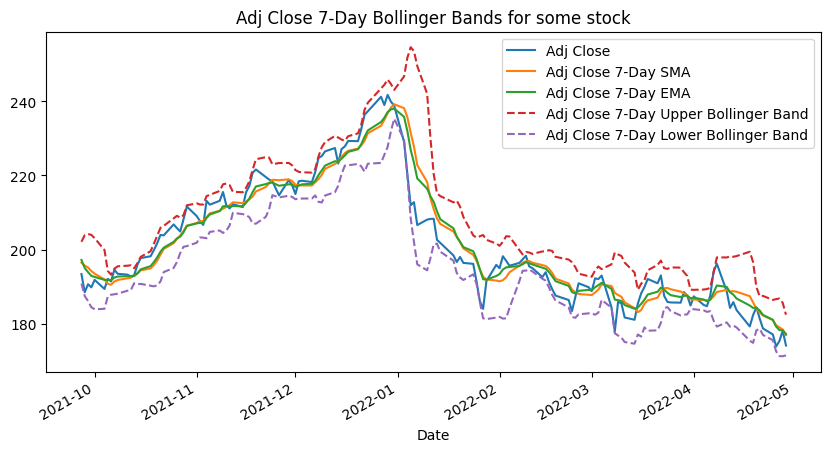

In [17]:
# Plot SMA, EMA and price. Note how EMA responds quicker to price swings than SMA
cols_to_plot = ['Adj Close', 'Adj Close 7-Day SMA', 'Adj Close 7-Day EMA', 'Adj Close 7-Day Upper Bollinger Band', 'Adj Close 7-Day Lower Bollinger Band']
line_styles = {'Adj Close 7-Day Upper Bollinger Band': '--', 'Adj Close 7-Day Lower Bollinger Band': '--'}
ax = test_df.plot(x ='Date', y=cols_to_plot, figsize=(10, 5), style=line_styles, title='Adj Close 7-Day Bollinger Bands for some stock')
ax.legend(bbox_to_anchor=(1, 1))

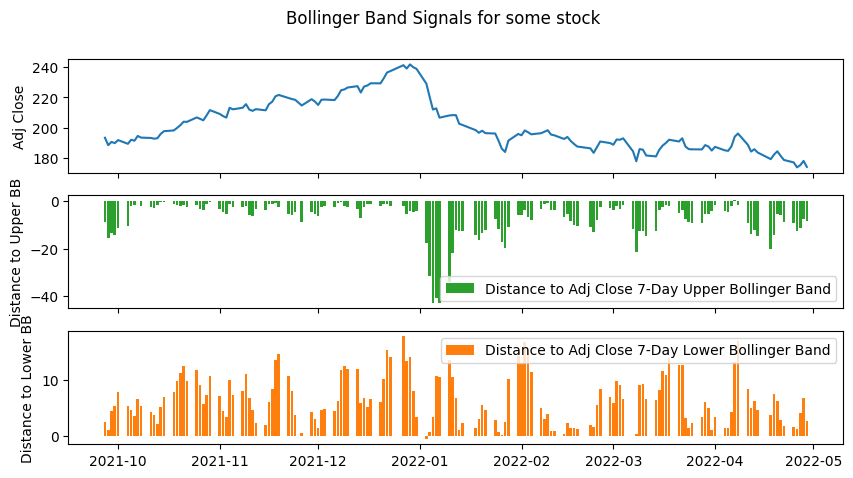

In [18]:
# Plot price vs distance to bollinger bands
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 5))

# Plot the stock price on the first (top) subplot
ax1.plot(test_df['Date'], test_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the BBs and distance to BBs on the second (bottom) subplot
ax2.bar(test_df['Date'], test_df['Distance to Adj Close 7-Day Upper Bollinger Band'], color='tab:green', label='Distance to Adj Close 7-Day Upper Bollinger Band')
ax3.bar(test_df['Date'], test_df['Distance to Adj Close 7-Day Lower Bollinger Band'], color='tab:orange', label='Distance to Adj Close 7-Day Lower Bollinger Band')
ax2.set_ylabel('Distance to Upper BB')
ax3.set_ylabel('Distance to Lower BB')
ax2.legend()
ax3.legend()
fig.suptitle('Bollinger Band Signals for some stock')
plt.show()

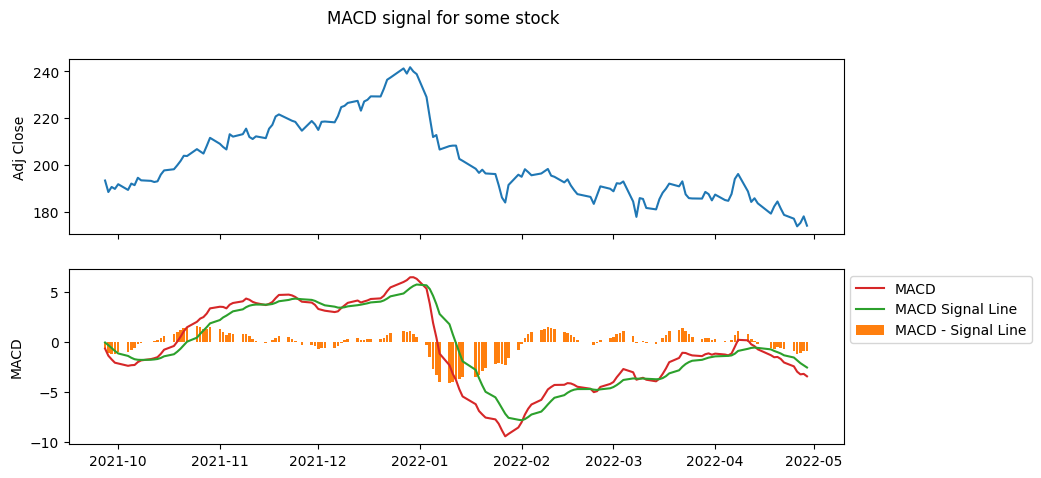

In [19]:
# Plot MACD and MACD Signal for some stock
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(test_df['Date'], test_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the MACD line and signal line on the second (bottom) subplot
ax2.plot(test_df['Date'], test_df['MACD'], color='tab:red', label='MACD')
ax2.plot(test_df['Date'], test_df['MACD Signal Line'], color='tab:green', label='MACD Signal Line')
ax2.bar(test_df['Date'], test_df['MACD Histogram'], color='tab:orange', label='MACD - Signal Line')
ax2.set_ylabel('MACD')
ax2.legend(bbox_to_anchor=(1, 1))
fig.suptitle('MACD signal for some stock')
plt.show()

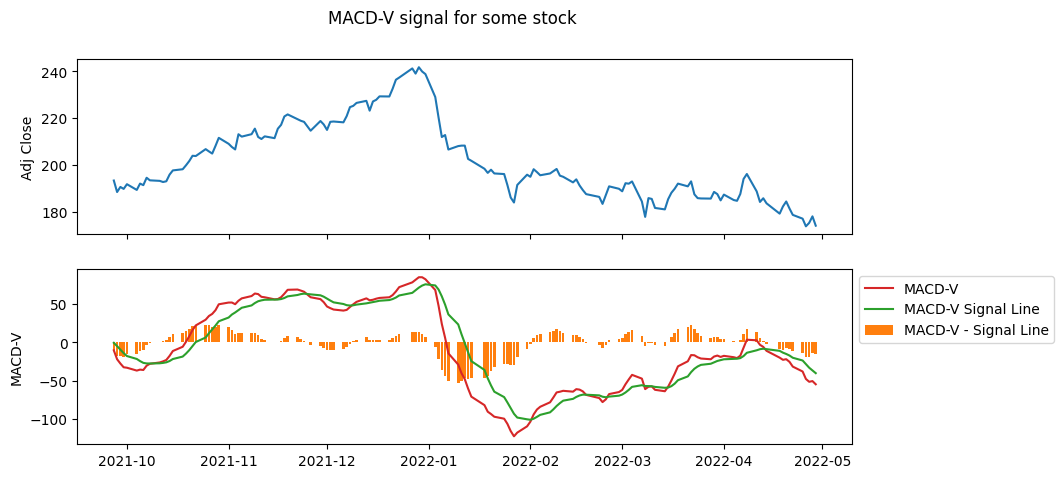

In [20]:
# Plot MACD-V and MACD-V Signal for some stock
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(test_df['Date'], test_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the MACD-V line and signal line on the second (bottom) subplot
ax2.plot(test_df['Date'], test_df['MACD-V'], color='tab:red', label='MACD-V')
ax2.plot(test_df['Date'], test_df['MACD-V Signal Line'], color='tab:green', label='MACD-V Signal Line')
ax2.bar(test_df['Date'], test_df['MACD-V Histogram'], color='tab:orange', label='MACD-V - Signal Line')
ax2.set_ylabel('MACD-V')
ax2.legend(bbox_to_anchor=(1, 1))
fig.suptitle('MACD-V signal for some stock')
plt.show()

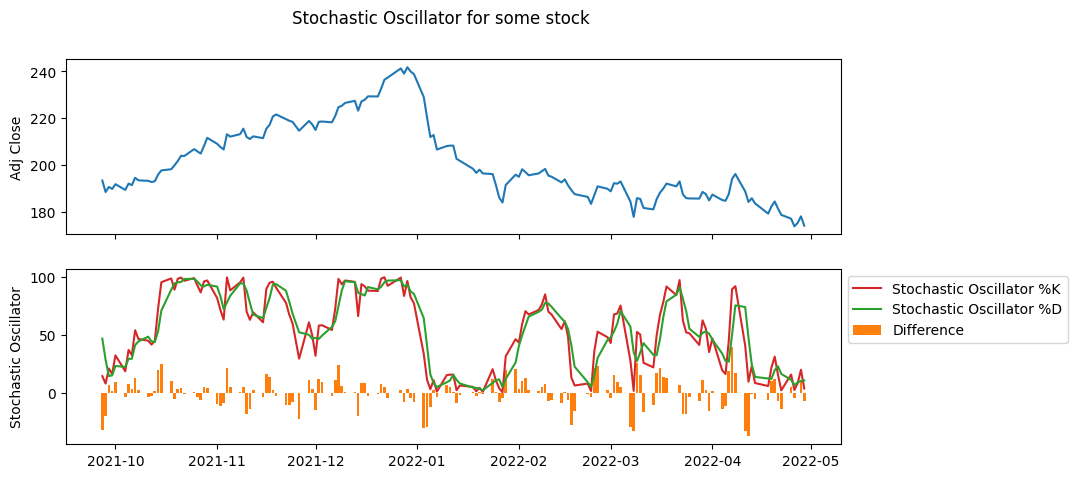

In [21]:
# Plot stochastic oscillator for some stock
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(test_df['Date'], test_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the stochastic oscillator and signal line on the second (bottom) subplot
ax2.plot(test_df['Date'], test_df['Stochastic Oscillator %K'], color='tab:red', label='Stochastic Oscillator %K')
ax2.plot(test_df['Date'], test_df['Stochastic Oscillator %D'], color='tab:green', label='Stochastic Oscillator %D')
ax2.bar(test_df['Date'], test_df['Stochastic Oscillator Histogram'], color='tab:orange', label='Difference')
ax2.set_ylabel('Stochastic Oscillator')
ax2.legend(bbox_to_anchor=(1, 1))
fig.suptitle('Stochastic Oscillator for some stock')
plt.show()

# Stationarity Analysis

#### Utility functions for ADF Tests

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
# Get stocks to perform adf test on
import random
n_stocks = 1
stocks = random.sample(
    list(df['Symbol'].unique()),
    n_stocks
)

In [24]:
def adf_test_macro(df, cols):
    """Function to perform ADF test on the desired macro-related columns"""
    
    # Get macro-related data ready for ADF test
    df_macro = df[['Date'] + cols].drop_duplicates(subset='Date')
    df_macro.set_index('Date', inplace=True)
    df_macro.dropna(ignore_index=True, inplace=True)

    # List of results dataframes
    results_dfs = []

    # Run tests for macro-related column
    for c in cols: 
        # Run test
        result = adfuller(df_macro[c])

        # Get test statistic
        test_stat = result[0]

        # Get p value
        p_value = result[1]

        # Get 1% and 5% critical values
        c_1_percent_critical = result[4]['1%']
        c_5_percent_critical = result[4]['5%']

        # Get conclusion
        c_1_percent_conclusion = 'Reject Null: Stationary' if p_value < 0.01 else 'Fail to Reject Null: Non-Stationary'
        c_5_percent_conclusion = 'Reject Null: Stationary' if p_value < 0.05 else 'Fail to Reject Null: Non-Stationary' 

        # Construct rows for dataframe (one for price, one for volume) 
        row = {
            'Column': [c],
            'Test Statistic': [test_stat],
            'p-Value': [p_value],
            '1% Critical Value': [c_1_percent_critical],
            '5% Critical Value': [c_5_percent_critical],
            '1% Conclusion': [c_1_percent_conclusion],
            '5% Conclusion': [c_5_percent_conclusion]
        }

        results_df = pd.DataFrame(row)
        results_dfs.append(results_df)

    # Join results dataframes together
    results = pd.concat(results_dfs)
    
    return results

In [25]:
def adf_test_stocks(df, stocks, cols):
    """Function to perform ADF tests for the desired stocks and desired columns"""
    
    # Create dataframe with necessary stocks and columns
    df_stocks = df[df['Symbol'].isin(stocks)].copy()
    df_stocks = df_stocks[['Date', 'Symbol'] + cols].copy()
    df_stocks.set_index('Date', inplace=True)
    df_stocks.dropna(ignore_index=True, inplace=True)
    
    # List of all results dataframes
    all_results_dfs = []

    # Run tests for each stock
    for s in stocks:
        # Get data
        data = df_stocks[df_stocks['Symbol'] == s]
        
        # List of results dataframes
        results_dfs = []

        # Run tests for stock-related column
        for c in cols: 
            # Run test
            result = adfuller(df_stocks[c])

            # Get test statistic
            test_stat = result[0]

            # Get p value
            p_value = result[1]

            # Get 1% and 5% critical values
            c_1_percent_critical = result[4]['1%']
            c_5_percent_critical = result[4]['5%']

            # Get conclusion
            c_1_percent_conclusion = 'Reject Null: Stationary' if p_value < 0.01 else 'Fail to Reject Null: Non-Stationary'
            c_5_percent_conclusion = 'Reject Null: Stationary' if p_value < 0.05 else 'Fail to Reject Null: Non-Stationary' 

            # Construct rows for dataframe
            row = {
                'Stock': [s],
                'Column': [c],
                'Test Statistic': [test_stat],
                'p-Value': [p_value],
                '1% Critical Value': [c_1_percent_critical],
                '5% Critical Value': [c_5_percent_critical],
                '1% Conclusion': [c_1_percent_conclusion],
                '5% Conclusion': [c_5_percent_conclusion]
            }
            
            # Create results dataframe
            results_df = pd.DataFrame(row)
            results_dfs.append(results_df)

        # Join all results
        results = pd.concat(results_dfs)
        all_results_dfs.append(results)

    # Join all results
    all_results = pd.concat(all_results_dfs)
    
    return all_results

#### Stationarity of Macro-Related Columns

In [26]:
# Get macro-related columns to perform ADF test on
adf_cols_macro = list(df.columns)
index = adf_cols_macro.index('Year')
adf_cols_macro = adf_cols_macro[index:]
adf_cols_macro.remove('1-week Forward Return Sign')
adf_cols_macro = [c for c in adf_cols_macro if any(c.startswith(prefix) for prefix in macro_cols + ['S&P500'])]

In [27]:
# Perform ADF Test for cols related to macro variables
results = adf_test_macro(
    df=df,
    cols=adf_cols_macro
)
results

,Column,Test Statistic,p-Value,1% Critical Value,5% Critical Value,1% Conclusion,5% Conclusion
0,Unemployment Rate (%) 1-Day Shifted,-3.124024,0.024826,-3.433766,-2.863049,Fail to Reject Null: Non-Stationary,Reject Null: Stationary
0,Consumer Confidence Index 1-Day Shifted,-2.459312,0.125691,-3.433727,-2.863032,Fail to Reject Null: Non-Stationary,Fail to Reject Null: Non-Stationary
0,CPI All Items 1-Day Shifted,2.394810,0.999008,-3.433769,-2.863050,Fail to Reject Null: Non-Stationary,Fail to Reject Null: Non-Stationary
0,Inflation (%) 1-Day Shifted,-0.370990,0.914831,-3.433768,-2.863050,Fail to Reject Null: Non-Stationary,Fail to Reject Null: Non-Stationary
0,Monthly Average Mortgage Rate (%) 1-Day Shifted,-1.382995,0.590401,-3.433768,-2.863050,Fail to Reject Null: Non-Stationary,Fail to Reject Null: Non-Stationary
...,...,...,...,...,...,...,...
0,Corporate Bond Yield 60-Day % Change,-3.960833,0.001630,-3.433762,-2.863047,Reject Null: Stationary,Reject Null: Stationary
0,GDP Per Capita 60-Day % Change,-4.515094,0.000185,-3.433734,-2.863035,Reject Null: Stationary,Reject Null: Stationary
0,Quarterly Real GDP 60-Day % Change,-4.887955,0.000037,-3.433732,-2.863034,Reject Null: Stationary,Reject Null: Stationary
0,Quarterly GDP Growth Rate (%) 60-Day % Change,-5.146553,0.000011,-3.433732,-2.863034,Reject Null: Stationary,Reject Null: Stationary


In [28]:
# Get all non-stationary columns (at 5% significance) related to macro columns
non_stationary_macro_cols = results[results['5% Conclusion'] == 'Fail to Reject Null: Non-Stationary']['Column'].unique()
non_stationary_macro_cols

array(['Consumer Confidence Index 1-Day Shifted',
       'CPI All Items 1-Day Shifted', 'Inflation (%) 1-Day Shifted',
       'Monthly Average Mortgage Rate (%) 1-Day Shifted',
       'Corporate Bond Yield 1-Day Shifted',
       'GDP Per Capita 1-Day Shifted', 'Quarterly Real GDP 1-Day Shifted',
       'Home Price Index 1-Day Shifted', 'S&P500 1-Day Shifted',
       'Consumer Confidence Index 3-Day Shifted',
       'CPI All Items 3-Day Shifted', 'Inflation (%) 3-Day Shifted',
       'Monthly Average Mortgage Rate (%) 3-Day Shifted',
       'Corporate Bond Yield 3-Day Shifted',
       'GDP Per Capita 3-Day Shifted', 'Quarterly Real GDP 3-Day Shifted',
       'Home Price Index 3-Day Shifted', 'S&P500 3-Day Shifted',
       'Consumer Confidence Index 5-Day Shifted',
       'CPI All Items 5-Day Shifted', 'Inflation (%) 5-Day Shifted',
       'Monthly Average Mortgage Rate (%) 5-Day Shifted',
       'Corporate Bond Yield 5-Day Shifted',
       'GDP Per Capita 5-Day Shifted', 'Quarterly Real

#### Stationarity of Stock-Related Columns

In [29]:
# Get stock related columns to perform ADF test on
adf_cols_stocks = list(df.columns)
index = adf_cols_stocks.index('Year')
adf_cols_stocks = adf_cols_stocks[index:]
adf_cols_stocks.remove('1-week Forward Return Sign')
adf_cols_stocks = [c for c in adf_cols_stocks if not any(c.startswith(prefix) for prefix in macro_cols + ['S&P500'])]

In [30]:
# Perform ADF Test for cols related to stocks
results = adf_test_stocks(
    df=df,
    stocks=stocks,
    cols=adf_cols_stocks
)
results

,Stock,Column,Test Statistic,p-Value,1% Critical Value,5% Critical Value,1% Conclusion,5% Conclusion
0,173,Year,-0.593424,8.724610e-01,-3.433727,-2.863032,Fail to Reject Null: Non-Stationary,Fail to Reject Null: Non-Stationary
0,173,Month,-4.658312,1.007107e-04,-3.433727,-2.863032,Reject Null: Stationary,Reject Null: Stationary
0,173,Day,-9.249224,1.508030e-15,-3.433773,-2.863052,Reject Null: Stationary,Reject Null: Stationary
0,173,Daily Variation,-6.508446,1.115877e-08,-3.433748,-2.863041,Reject Null: Stationary,Reject Null: Stationary
0,173,Downward Pressure,-6.011823,1.566876e-07,-3.433764,-2.863048,Reject Null: Stationary,Reject Null: Stationary
...,...,...,...,...,...,...,...,...
0,173,MACD-V Signal Line,-6.335930,2.830822e-08,-3.433753,-2.863043,Reject Null: Stationary,Reject Null: Stationary
0,173,MACD-V Histogram,-10.644056,4.846643e-19,-3.433755,-2.863044,Reject Null: Stationary,Reject Null: Stationary
0,173,Stochastic Oscillator %K,-9.620446,1.714728e-16,-3.433764,-2.863048,Reject Null: Stationary,Reject Null: Stationary
0,173,Stochastic Oscillator %D,-7.951242,3.121797e-12,-3.433773,-2.863052,Reject Null: Stationary,Reject Null: Stationary


In [31]:
# Get all non-stationary columns (at 5% significance) related to stock columns
non_stationary_stock_cols = results[results['5% Conclusion'] == 'Fail to Reject Null: Non-Stationary']['Column'].unique()
non_stationary_stock_cols

array(['Year', 'Adj Close 1-Day Shifted', 'Close 1-Day Shifted',
       'High 1-Day Shifted', 'Low 1-Day Shifted', 'Open 1-Day Shifted',
       'Adj Close 3-Day Shifted', 'Close 3-Day Shifted',
       'High 3-Day Shifted', 'Low 3-Day Shifted', 'Open 3-Day Shifted',
       'Adj Close 5-Day Shifted', 'Close 5-Day Shifted',
       'High 5-Day Shifted', 'Low 5-Day Shifted', 'Open 5-Day Shifted',
       'Adj Close 10-Day Shifted', 'Close 10-Day Shifted',
       'High 10-Day Shifted', 'Low 10-Day Shifted', 'Open 10-Day Shifted',
       'Adj Close 15-Day Shifted', 'Close 15-Day Shifted',
       'High 15-Day Shifted', 'Low 15-Day Shifted', 'Open 15-Day Shifted',
       'Adj Close 30-Day Shifted', 'Close 30-Day Shifted',
       'High 30-Day Shifted', 'Low 30-Day Shifted', 'Open 30-Day Shifted',
       'Adj Close 60-Day Shifted', 'Close 60-Day Shifted',
       'High 60-Day Shifted', 'Low 60-Day Shifted', 'Open 60-Day Shifted',
       'Adj Close 7-Day SMA', 'Adj Close 7-Day EMA',
       'Adj Clos

# Stationarity Transformations

#### Macro Columns
Most of the non-stationary macro-related columns were just shifted values. We can drop these. However HPI percentage changes were also non-stationary so we transform these. We also transform the macro features that were found to be non-stationary from the EDA notebook.

In [32]:
# Drop non-stationary cols that are just shifted values
to_drop = [c for c in non_stationary_macro_cols if c.endswith('Shifted')]
df.drop(to_drop, axis=1, inplace=True)

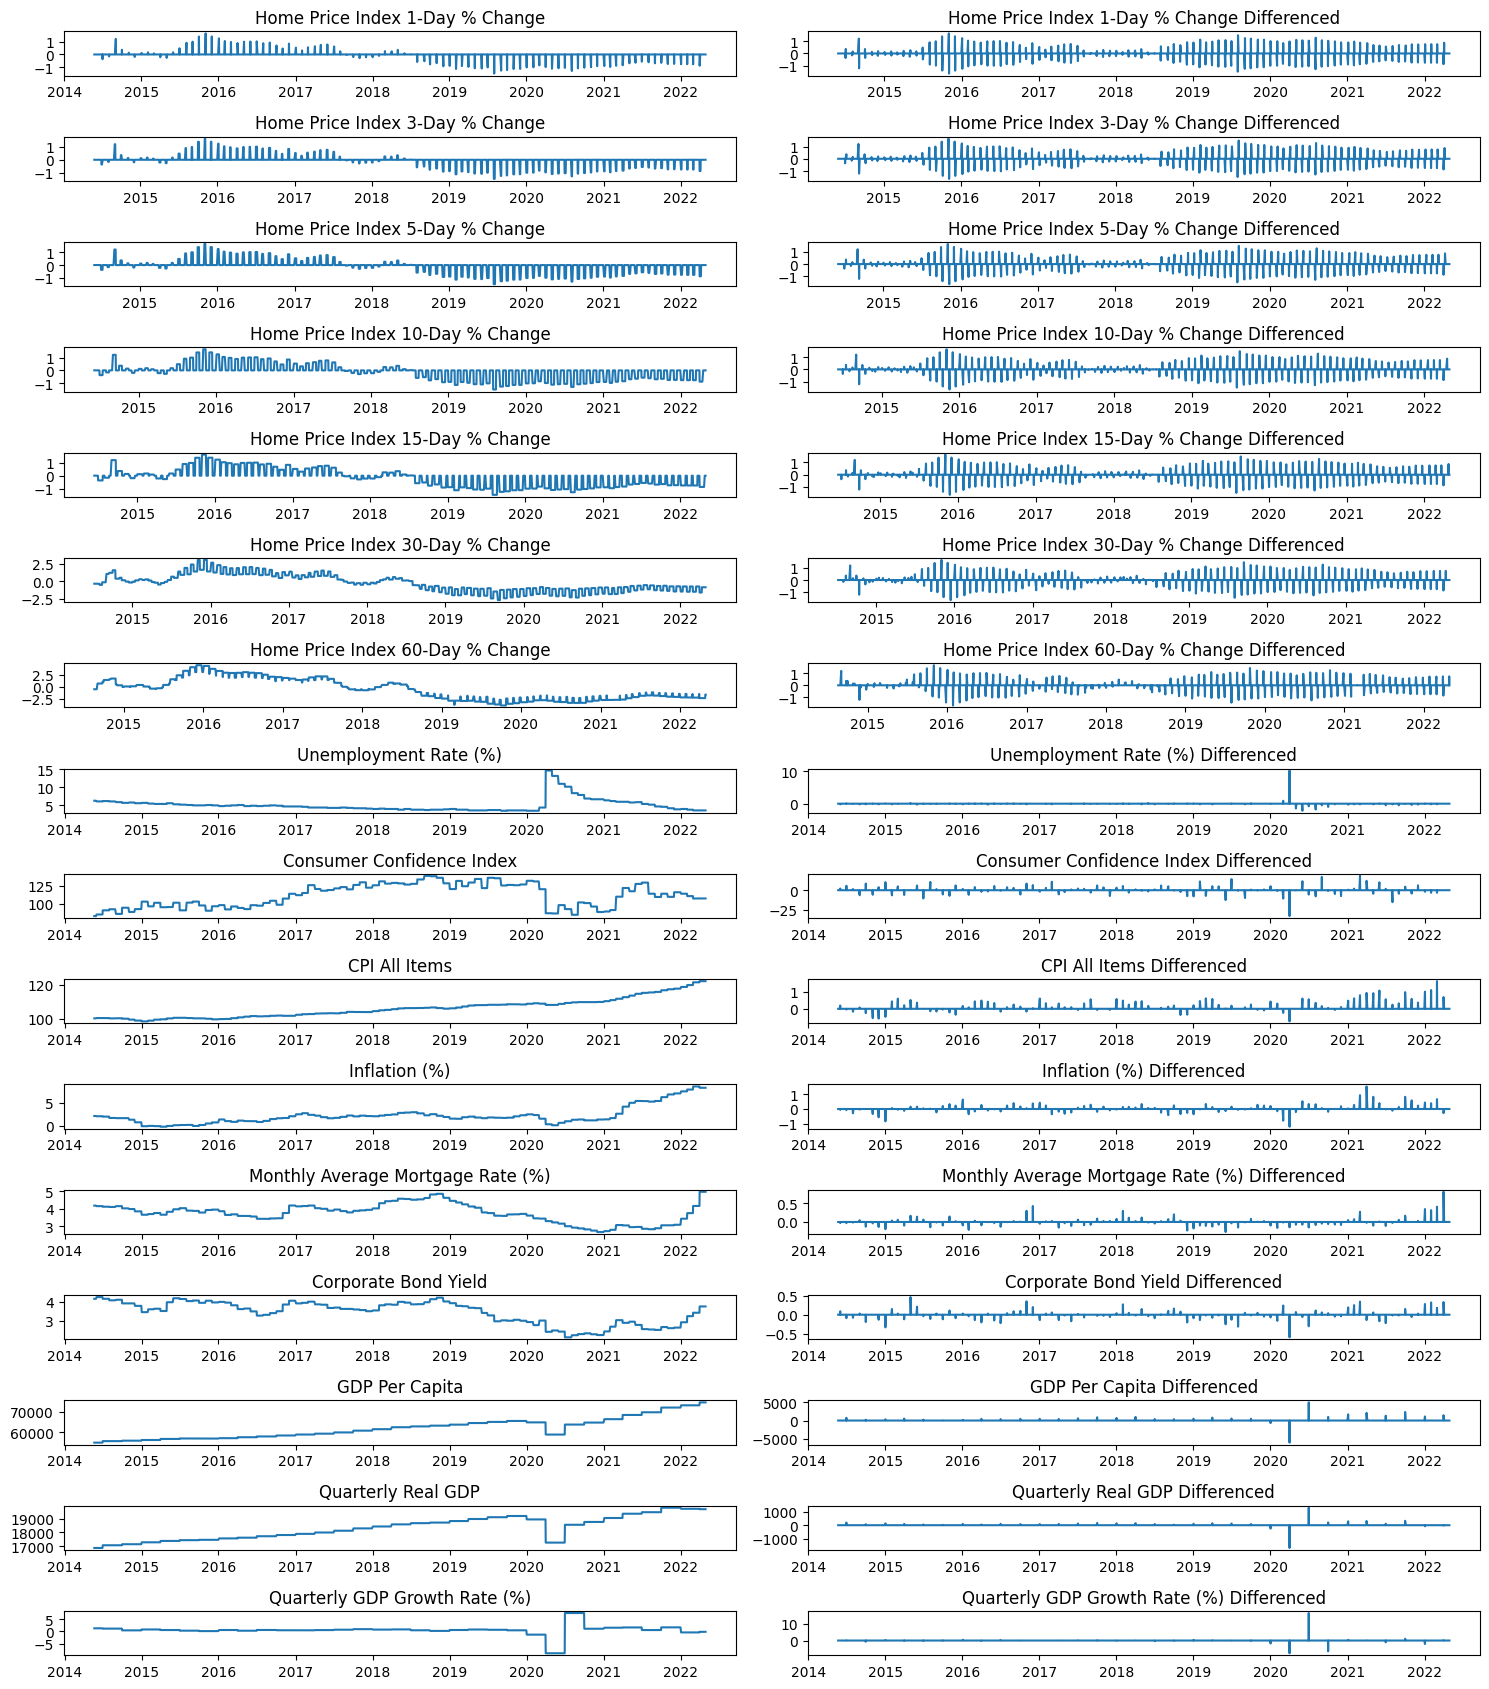

In [33]:
# Use first order differencing to trasnform columns
to_transform = [c for c in non_stationary_macro_cols if not c.endswith('Shifted')] +  [m for m in macro_cols if m != 'Home Price Index']
transformed_col_names = [f"{c} Differenced" for c in to_transform]
df[transformed_col_names] = df.groupby('Symbol')[to_transform].transform(lambda x: x.diff())

# Plot before and after transformation
fig, axes = plt.subplots(len(to_transform), 2, figsize=(15, 17))
for i, (c1, c2) in enumerate(zip(to_transform, transformed_col_names)):
    axes[i, 0].plot(df['Date'], df[c1])
    axes[i, 1].plot(df['Date'], df[c2])
    axes[i, 0].set_title(c1)
    axes[i, 1].set_title(c2)
plt.tight_layout()
plt.show()

# Drop columns that were transformed
df.drop(to_transform, axis=1, inplace=True)

In [34]:
# Perform ADF Test for transformed columns
results = adf_test_macro(
    df=df,
    cols=transformed_col_names
)
results['5% Conclusion'].value_counts()

5% Conclusion
Reject Null: Stationary    16
Name: count, dtype: int64

#### Stock Columns
Lots of shifted values are non-stationary so we transform these, some other features and the columns that were found to be non-stationary in the EDA notebook

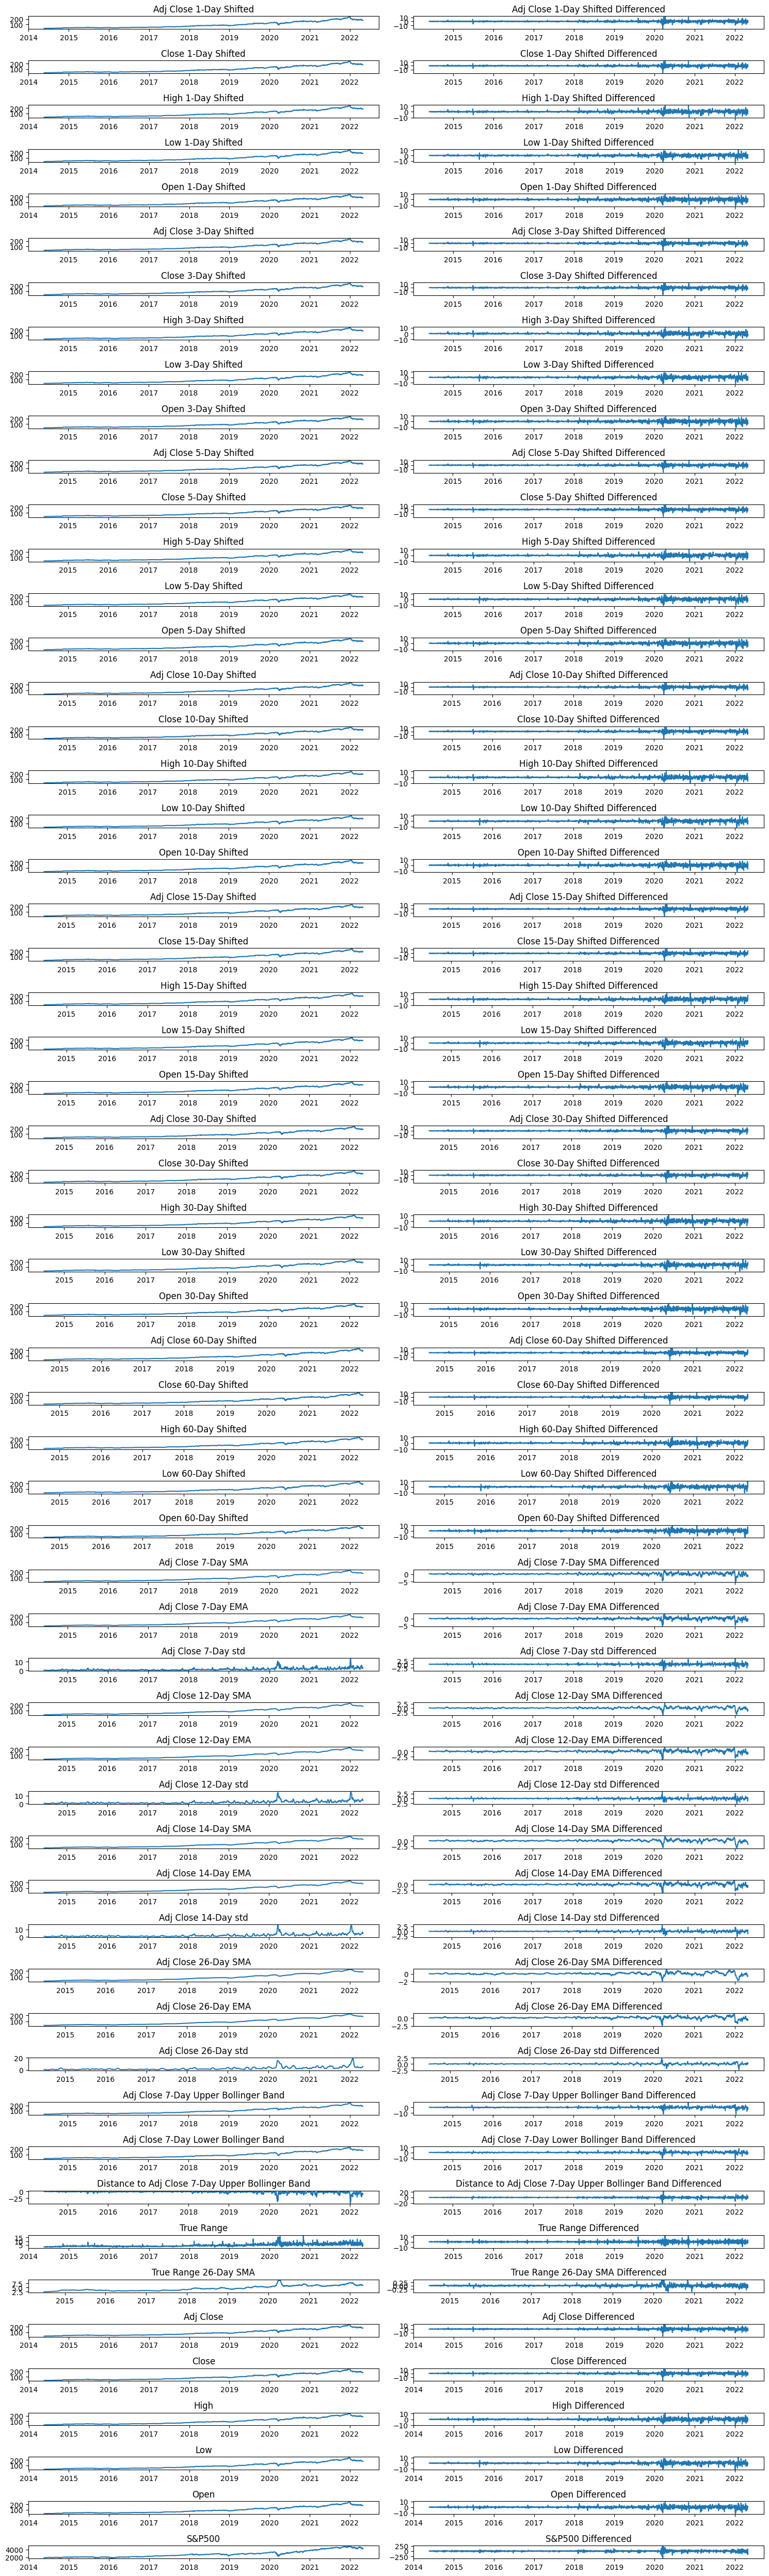

In [35]:
# Use first order differencing to trasnform columns
to_transform = [c for c in non_stationary_stock_cols if c != 'Year'] + ['Adj Close', 'Close', 'High', 'Low', 'Open', 'S&P500']
transformed_col_names = [f"{c} Differenced" for c in to_transform]
df[transformed_col_names] = df.groupby('Symbol')[to_transform].transform(lambda x: x.diff())

# Data to do plots for 1 stock
df1 = df[df['Symbol'] == 1]

# Plot before and after transformation
fig, axes = plt.subplots(len(to_transform), 2, figsize=(15, 50))
for i, (c1, c2) in enumerate(zip(to_transform, transformed_col_names)):
    axes[i, 0].plot(df1['Date'], df1[c1])
    axes[i, 1].plot(df1['Date'], df1[c2])
    axes[i, 0].set_title(c1)
    axes[i, 1].set_title(c2)
plt.tight_layout()
plt.show()

# Drop columns that were transformed
df.drop(to_transform, axis=1, inplace=True)

In [36]:
# Perform ADF Test for transformed columns
results = adf_test_stocks(
    df=df,
    stocks=stocks,
    cols=transformed_col_names
)
results['5% Conclusion'].value_counts()

5% Conclusion
Reject Null: Stationary    58
Name: count, dtype: int64

# Write Output

In [37]:
# Drop redundant columns
redundant_cols = ['Date']
df.drop(redundant_cols, axis=1, inplace=True)

# Drop rows that have NaNs due to forward-looking target or back-looking features
df.dropna(ignore_index=True, inplace=True)

In [38]:
# Write to file
df.to_csv(path_or_buf="all_data.csv")